In [1]:
import kerchunk.hdf
import fsspec

In [10]:
CCI_ZARR_STORE_ENDPOINT = 's3://cate-kerchunk-test/'

storage_options=dict(
    key='',
    secret=''
)
fs = fsspec.filesystem('s3', use_listings_cache=False, **storage_options)

In [47]:
urls = []

for year in range(1979, 2019):
    for month in range(1, 13):
        root = f'cate-kerchunk-test/{year}/{month:02d}'
        if fs.exists(root):
            for file_info in fs.ls(root):
                if file_info.endswith('.nc'):
                    urls.append(f's3://{file_info}')

In [48]:
urls[0]

's3://cate-kerchunk-test/1979/01/19790106-ESACCI-L3C_SNOW-SWE-SMMR-NIMBUS7-fv1.0.nc'

In [49]:
fsspec.open(urls[0]).open()

<File-like object S3FileSystem, cate-kerchunk-test/1979/01/19790106-ESACCI-L3C_SNOW-SWE-SMMR-NIMBUS7-fv1.0.nc>

In [50]:
singles = []
for u in urls:
    with fsspec.open(u, **storage_options) as inf:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, u, inline_threshold=100)
        singles.append(h5chunks.translate())

In [52]:
from kerchunk.combine import MultiZarrToZarr

In [54]:
mzz = MultiZarrToZarr(
    singles,
    remote_protocol="s3",
    remote_options={
        # 'anon': True
        'key': '',
        'secret': ''
    },
    concat_dims=["time"]
)

out = mzz.translate()

In [2]:
import xarray as xr

In [7]:
ds = xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": out,
            "remote_protocol": "s3",
            "remote_options": {
                'key': '',
                'secret': ''
            }
        },
        "consolidated": False
    }
)

In [8]:
ds

<xarray.Dataset>
Dimensions:      (lat: 720, time: 7397, nv: 2, lon: 1440)
Coordinates:
  * lat          (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon          (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time         (time) datetime64[ns] 1979-01-06 1979-01-08 ... 2018-05-31
Dimensions without coordinates: nv
Data variables:
    lat_bnds     (time, lat, nv) float64 ...
    lon_bnds     (time, lon, nv) float64 ...
    spatial_ref  (time) float64 ...
    swe          (time, lat, lon) float64 ...
    swe_std      (time, lat, lon) float64 ...
Attributes: (12/42)
    Conventions:                CF-1.7
    cdm_data_type:              grid
    comment:                    The following auxiliary datasets are used for...
    creator_email:              kari.luojus@fmi.fi (Scientific and Production...
    creator_name:               Finnish Meteorological Institute
    creator_url:                www.fmi.fi
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19790106T235959Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19790106T000000Z
    title:                      ESA CCI snow SWE product level L3C daily
    tracking_id:                4bcd563d-f07b-4046-b55a-06988a96aee8

In [9]:
ds.swe

<xarray.DataArray 'swe' (time: 7397, lat: 720, lon: 1440)>
[7669209600 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 1979-01-06 1979-01-08 ... 2018-05-31
Attributes:
    actual_range:         [1, 202]
    ancillary_variables:  swe_std
    flag_meanings:        Glacier Mountain Water no_data no_snow
    flag_values:          [-30, -20, -10, -1, 0]
    grid_mapping:         spatial_ref
    long_name:            Snow Water Equivalent
    units:                mm
    valid_range:          [1, 500]

In [ ]:
ds.swe.mean()

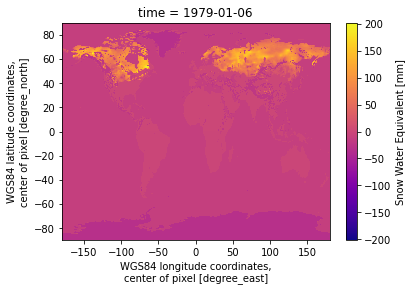

In [11]:
ds.swe.isel(time=0).plot.imshow(cmap='plasma')

In [6]:
out

{'version': 1,
 'refs': {'.zgroup': '{"zarr_format":2}',
  'time/.zarray': '{\n    "chunks": [\n        7397\n    ],\n    "compressor": {\n        "id": "zstd",\n        "level": 1\n    },\n    "dtype": "<f4",\n    "fill_value": 0.0,\n    "filters": null,\n    "order": "C",\n    "shape": [\n        7397\n    ],\n    "zarr_format": 2\n}',
  'time/0': 'base64:KLUv/WCUcnWRAk45B4oUQRB4pwrpDuUyCs4xenk0w6iP5cBqDOM4xcgLslA/1G8Cj7AjfAUjvvYWh8VhcVhUGDKRTWQT2USmaDUaTe2Q7e2kYhQcFPsTd0wHd4wGd8wFdwwFd0wEd4wDd8wCdwwCd0wBd4wAd8zwjgHgjgHeMT13zM4dw7tMcy6T3WWqu0yCXCa4y/R2mdxcprXLlHaZ2lwmNpeJ7DKNXSY+LpPXZeq6THpcJjSXCesynblMZi7T1GWSukx2XKamy8R0mei4TGEu09FlAnOZ4rhMXi6T0GV64zJhuUxWLhMbl2nKZQK6TFAuExqXicllUnKZzLhMSC5TkcsUxmXy4jJtcZmwuExVXCYpLtMTl4mJy5TEZTLiMg1xmYC4TD1cJh0u0w2XqZdphssEw2Vq4TKpcJlOuEwkXKYQLpMHl2mDy4TBZargMklwmR64TAxcpgQukwGXaYDL9HOZhJdpyGX6XSaey6Rzmb5Ld3dpkLs0d5fi7hKcu/TmLrHdJbW79MddMrtLZXepj7sUdpe+7pKau5TmLmndpay7hMddqrpLVHfpjrsEdZec7tKYuyTmLiXdJaS7JMddIrpLQ3cJjru05S5luUtX7lIbd4nKXZJyl9S4S2nc